In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import export_graphviz
import graphviz
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from typing import List, Tuple

## <hr><center>Load the datasets prepared by the `ClassificationPrepare` Notebook</center></hr>

In [ ]:
# Load the training dataset.
 
train_X = np.loadtxt("../data_classification/train_X.csv", delimiter=",")
print(f'(train_X) Loading {train_X.shape[0]} from "../data_classification/train_X.csv"')
train_y = np.loadtxt("../data_classification/train_y.csv", delimiter=",")
print(f'(train_y) Loading {train_y.shape[0]} from "../data_classification/train_y.csv"')

# Load the test dataset.

test_X = np.loadtxt("../data_classification/test_X.csv", delimiter=",")
print(f'(test_X) Loading {test_X.shape[0]} from "../data_classification/test_X.csv"')
test_y = np.loadtxt("../data_classification/test_y.csv", delimiter=",")
print(f'(test_y) Loading {test_y.shape[0]} from "../data_classification/test_y.csv"')

# Normalize data
scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

(train_X) Loading 1505 from "data/stage2/train_X.csv"
(train_y) Loading 1505 from "data/stage2/train_y.csv"
(test_X) Loading 377 from "data/stage2/test_X.csv"
(test_y) Loading 377 from "data/stage2/test_y.csv"


## <hr><center>Common definitions for all classifiers</center></hr>

In [ ]:
# All model classifiers are collected in this dictionary by using a common function decorator.
all_classifiers = {}

# Custom model decorator to be able to find and run all models in an uniform way.
# A classifier lambda is required in the "model" attribute.
def model_decorator(name):
    def decorator(model):
        all_classifiers[name] = {'model': model}
        return model
    return decorator

# Run all classifiers corresponding with the "classifiers" label.
def run_classifiers(classifiers, train_X, train_y, test_X, test_y):
    for name, classifier in classifiers.items():
        run_classifier(name, classifier, train_X, train_y, test_X, test_y)

# Run a single classifier with the given name.
def run_classifier_by_name(name, train_X, train_y, test_X, test_y):
    run_classifier(name, all_classifiers[name], train_X, train_y, test_X, test_y)
    
# Main run_classifier function.
# :param name: Name of the classifier.
# :param classifier: Classifier object: a dictionary with a classifier lambda in 'model'.
# :param train_X: Training data.
# :param train_y: Training labels.
# :param test_X: Test data.
# :param test_y: Test labels.
def run_classifier(name, classifier, train_X, train_y, test_X, test_y):

    print("-- Model: ", name, "--")
    
    # Run the classifier lambda.
    prediction_function = classifier['model'](train_X, train_y)
    
    # Get the predictions.
    predict_train = prediction_function(train_X)
    predict_test  = prediction_function(test_X)
            
    # Print train and test accuracy.
    print('Train accuracy:', accuracy_score(train_y, predict_train))
    print('Test accuracy:', accuracy_score(test_y, predict_test))
    
    # Print classification report.
    print('Train classification report:')
    print(classification_report(train_y, predict_train))

    print('Test Classification report:')
    print(classification_report(test_y, predict_test))
    
    # Plot confusion matrix.
    cm = confusion_matrix(test_y, predict_test)
    plt.matshow(cm)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Add labels to each cell of the confusion matrix.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
    plt.show()

## <hr><center>Models</center><hr>

We present here a section for each model we tried on the dataset.

The model constructions are all self-explanatory, with the grid searches being defined in a uniform way and using GridSearchCV to present the list of parameters.

The functions defined here all present a common interface which is then used to predict on train and test dataset.

# KNN

In [ ]:
@model_decorator('knn')
def model_knn_grid_search(train_X, train_y, test_X, test_y):
    model = KNeighborsClassifier()
    params = {
        'n_neighbors': list(range(2, 50)),
        'weights': ['uniform', 'distance'],
        'algorithm': [ 'ball_tree', 'kd_tree', 'brute'],
        'metric': ['minkowski'],
        'p': [1, 2] # p-norm, 1 = Manhattan, 2 = Euclidean
    }
    grid_search = GridSearchCV(model, params, cv=3, n_jobs=-1)
    grid_search.fit(train_X, train_y)
    print(f'Best params: {grid_search.best_params_}')
    return grid_search.best_estimator_.predict

# Logistic Regression

In [ ]:
@model_decorator('logistic_regression')
def model_logistic_regression(train_X, train_y, test_X, test_y):
    model = LogisticRegression()
    params = {
        'C': np.random.uniform(0.0001, 0.5, size=30),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [10000],
        'class_weight': ['balanced', None]
    }
    grid_search = GridSearchCV(model, params, cv=3, n_jobs=-1)
    grid_search.fit(train_X, train_y)
    print(f'Best params: {grid_search.best_params_}')
    return grid_search.best_estimator_.predict

# Naive Bayes

In [ ]:
@model_decorator('bayes')
def model_bayes(train_X, train_y, test_X, test_y):
    priors = np.unique(train_y, return_counts=True)[1]
    priors = priors / priors.sum()
    model = GaussianNB(priors=priors)
    return model.fit(train_X, train_y).predict

# SVM

In [ ]:
@model_decorator('svm')
def model_svm(train_X, train_y, test_X, test_y):
    model = SVC()
    # RBF kernel
    # # Initial broad search
    # params = {
    #     'C': np.random.uniform(0.0001, 0.5, size=10),
    #     'kernel': ['rbf'],
    #     'gamma': np.random.uniform(0.0001, 0.5, size=10),
    #     'shrinking': [True, False],
    #     'probability': [True, False],
    # }
    # # results: 'C': 0.4786995895467172, 'gamma': 0.08694625970414771, 'kernel': 'rbf', 'probability': True, 'shrinking': True
    # # finer grid search:
    # params = {
    #     'C': np.random.uniform(0.1, 1, size=10),
    #     'kernel': ['rbf'],
    #     'gamma': np.random.uniform(0.01, 1, size=10),
    #     'shrinking': [True, False],
    #     'probability': [True, False],
    # }
    # # 'C': 0.736944154680953, 'gamma': 0.28274937807806205, 'kernel': 'rbf', 'probability': True, 'shrinking': True
    # params = {
    #     'C': np.random.uniform(0.6, 2, size=10),
    #     'kernel': ['rbf'],
    #     'gamma': np.random.uniform(0.1, 1, size=10),
    #     'shrinking': [True, False],
    #     'probability': [True, False],
    # }
    # # 'C': 1.1762465067853318, 'gamma': 0.4538956433611281, 'kernel': 'rbf', 'probability': True, 'shrinking': True
    params = {
         'C': np.random.uniform(0.6, 1.3, size=10),
         'kernel': ['rbf'],
         'gamma': np.random.uniform(0.25, 0.5, size=10),
         'shrinking': [True, False],
         'probability': [True, False],
    }
    # Best params: {'C': 1.2778817904850097, 'gamma': 0.47902531791885644, 'kernel': 'rbf', 'probability': True, 'shrinking': True}
    params = {
         'C': [1.2778817904850097],
         'kernel': ['rbf'],
         'gamma': [0.47902531791885644],
         'shrinking': [True],
         'probability': [True, False],
    }

    # # Sigmod kernel
    # # Initial broad search
    # params = {
    #     'C': np.random.uniform(0.0001, 0.5, size=10),
    #     'kernel': ['sigmoid'],
    #     'gamma': np.random.uniform(0.0001, 0.5, size=10),
    #     'shrinking': [True, False],
    #     'probability': [True, False],
    # }
    # # results: 'C': 0.45955040264897107, 'gamma': 0.03719075583701472, 'kernel': 'sigmoid', 'probability': True, 'shrinking': True
    # # finer grid search:
    # params = {
    #     'C': np.random.uniform(0.1, 1, size=10),
    #     'kernel': ['sigmoid'],
    #     'gamma': np.random.uniform(0.01, 0.1, size=10),
    #     'shrinking': [True, False],
    #     'probability': [True, False],
    # }
    # # 'C': 0.6693226069904754, 'gamma': 0.032554091639207666, 'kernel': 'sigmoid', 'probability': True, 'shrinking': True
    # params = {
    #     'C': np.random.uniform(0.4, 0.8, size=10),
    #     'kernel': ['sigmoid'],
    #     'gamma': np.random.uniform(0.01, 0.05, size=10),
    #     'shrinking': [True, False],
    #     'probability': [True, False],
    # }

    ## Poly kernel
    ## Initial broad search
    #params = {
    #    'C': np.random.uniform(0.0001, 0.5, size=5),
    #    'kernel': ['poly'],
    #    'degree': np.random.uniform(1, 3, size=5),
    #    'gamma': np.random.uniform(0.0001, 0.5, size=5),
    #    'shrinking': [True, False],
    #    'probability': [True, False],
    #}
    # results: 'C': 0.22438374992061152, 'degree': 1.5659146627552227, 'gamma': 0.20465986148276036, 'kernel': 'poly', 'probability': True, 'shrinking': True
    # finer grid search:
    #params = {
    #    'C': np.random.uniform(0.01, 0.5, size=5),
    #    'kernel': ['poly'],
    #    'degree': list(range(1, 6)),
    #    'gamma': np.random.uniform(0.01, 0.5, size=5),
    #    'shrinking': [True, False],
    #    'probability': [True, False],
    #}
    # results: 'C': 0.01793599142055434, 'degree': 3, 'gamma': 0.35382342214177626, 'kernel': 'poly', 'probability': True, 'shrinking': True
    #params = {
    #    'C': np.random.uniform(0.005, 0.07, size=5),
    #    'kernel': ['poly'],
    #    'degree': list(range(2, 5)),
    #    'gamma': np.random.uniform(0.1, 0.6, size=5),
    #    'shrinking': [True, False],
    #    'probability': [True, False],
    #}
    # 'C': 0.015616564261866982, 'degree': 3, 'gamma': 0.2313457630496316, 'kernel': 'poly', 'probability': True, 'shrinking': True
    grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1)
    grid_search.fit(train_X, train_y)
    print(f'Best params: {grid_search.best_params_}')
    return grid_search.best_estimator_.predict

# Decision tree

In [ ]:
@model_decorator('dt')
def model_dt(train_X, train_y, test_X, test_y):
    model = DecisionTreeClassifier()
    params = {
        'max_depth': list(range(2, 20)),
        'min_samples_split': [3,4,5],
        'min_samples_leaf': [4,5],
        'class_weight': ['balanced', None],
        'criterion': ['gini', 'entropy']
    }
    grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1)
    grid_search.fit(train_X, train_y)
    print(f'Best params: {grid_search.best_params_}')
    ## Plot decision tree
    #dt = grid_search.best_estimator_
    #dot_data = export_graphviz(dt, out_file=None, feature_names=['avg_ace%', 'avg_df%', 'avg_1st%', 'avg_2ndWin%', 'avg_bpSaved%', 'avg_ptWon%', 
    # 'win_rate', 'n_matches', 'tournament_wins'], filled=True, rounded=True)
    #graph = graphviz.Source(dot_data)
    #graph.render("dt", view=True)
    return grid_search.best_estimator_.predict

# Random forest

In [ ]:
@model_decorator('rf')
def model_rf(train_X, train_y, test_X, test_y):
    model = RandomForestClassifier(n_estimators=30)
    #params = {
    #    "bootstrap": [True, False],
    #    "criterion": ["entropy", "gini"],
    #    "max_depth": list(range(2, 20)),
    #    "min_samples_split": list(range(1, 10)),
    #    "min_samples_leaf": list(range(1, 10)),
    #    "class_weight": ['balanced', None]
    #}
    # Result of the grid search (unbalanced)
    #params = {
    #    "bootstrap": [True],
    #    "criterion": ["gini"],
    #    "max_depth": [9],
    #    "min_samples_split": [8],
    #    "min_samples_leaf": [7],
    #    "class_weight": [None]
    #}
    # Result of the grid search (balanced)
    params = {
        "bootstrap": [False],
        "criterion": ["gini"],
        "max_depth": [18],
        "min_samples_split": [4],
        "min_samples_leaf": [1],
        "class_weight": [None]
    }
    grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1)
    grid_search.fit(train_X, train_y)
    print(f'Best params: {grid_search.best_params_}')
    return grid_search.best_estimator_.predict

# NN

In [ ]:
# Construct and return the TensorFlow model.
def create_model(hidden_layers, lr_rate):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(train_X.shape[1],)))
    model.add(Dense(hidden_layers[0][0], activation=hidden_layers[0][1]))
    for i in range(1, len(hidden_layers)):
        model.add(BatchNormalization())
        model.add(Dense(hidden_layers[i][0], activation=hidden_layers[i][1]))
        if hidden_layers[i][2] != 0:
            model.add(Dropout(hidden_layers[i][2]))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr_rate), metrics=['accuracy'])
    return model

# Grid search for the best hyperparameters, using holdout as cross validation.
def grid_search_holdout(train_X, train_y, val_X, val_y):   
    hidden_units = [8, 16, 32, 64, 128, 256]
    n_layers = [2,3]
    dropout_rates = [0, 0.3, 0.5]
    act_func = ['tanh', 'relu']
    lr_rates = np.linspace(1e-5, 1e-2, 10)

    # Best models found in the grid search. Decomment this part to get the best models.

    # # best balanced model
    # [(128, 'relu', 0.5), (128, 'relu', 0.5), (128, 'relu', 0.5)]
    hidden_units = [128]
    n_layers = [3]
    dropout_rates = [0.5]
    act_func = ['relu']
    lr_rates = [0.006670000000000001]

    # best *Unbalanced* model
    # [(128, 'tanh', 0.3), (128, 'tanh', 0.3), (128, 'tanh', 0.3)] lr=0.01 ep=381
    #hidden_units = [128]
    #n_layers = [3]
    #dropout_rates = [0.3]
    #act_func = ['tanh']
    #lr_rates = [0.01]

    max_epochs = 1500
    patience = 300
    batch_size = 256
    best_val_acc = 0
    best_lr_rate = 0
    best_model = None
    best_epochs = 0
    i = 0
    N = len(hidden_units) * len(n_layers) * len(dropout_rates) * len(act_func) * len(lr_rates)

    # Use the grid search to find the best model, applying the cartesian product of all the hyperparameters.
    for hidden_unit, n_layer, dropout_rate, act_func, lr_rate in product(hidden_units, n_layers, dropout_rates, act_func, lr_rates):
        # Construct the model based on the architecture.
        model_arch = [(hidden_unit, act_func, dropout_rate)] * n_layer
        model = create_model(model_arch, lr_rate)

        # Fit the model using the EarlyStopping callback.
        history = model.fit(train_X, train_y, epochs=max_epochs, batch_size=batch_size, verbose=0, validation_data=(val_X, val_y), callbacks=[EarlyStopping(monitor='val_loss', patience=patience)])
        best_epoch = len(history.history['val_accuracy'])-1
        acc = history.history['val_accuracy'][best_epoch]
        
        # Update the best model if the validation accuracy is better.
        if acc > best_val_acc:
            best_val_acc = acc
            best_model = model_arch
            best_lr_rate = lr_rate
            best_epochs = best_epoch

        # Print a progress bar for the grid search.
        print(f'{i}/{N} {best_model} lr={best_lr_rate} ep={best_epochs} acc={best_val_acc}')
        i += 1
    return best_model, best_lr_rate, best_epochs

In [ ]:
# Now we can use the best model to predict the test set.
# Note that we apply a retraining of the model with the best hyperparameters on the entire dataset.

def model_neural_network(train_X, train_y, val_X, val_y):
    best_model, best_lr_rate, best_epoch = grid_search_holdout(train_X, train_y, val_X, val_y)
    print(f'Best model: {best_model}')
    print(f'Best lr_rate: {best_lr_rate}')
    print(f'Best epoch: {best_epoch}')

    # Final retraining on the entire dataset.
    # Construct the model based on the architecture.
    model = create_model(best_model, best_lr_rate)
    history = model.fit(train_X, train_y,
                        validation_data=(test_X, test_y),
                        epochs=best_epoch+1,
                        batch_size=256,
                        verbose=0)
    
    # Get the predictions from the sigmoid function with the treshold.
    def threshold(x, threshold=0.5):
        return (x >= threshold).astype(int)

    return lambda x: threshold(model.predict(x))

def run_nn(train_X, train_y, test_X, test_y, balanced=False):
    train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
    if balanced:
        # Balance data with SMOTE
        sm = SMOTE(random_state=33)
        train_X, train_y = sm.fit_resample(train_X, train_y)
    prediction_function = model_neural_network(train_X, train_y, val_X, val_y)

    predict_train = prediction_function(train_X)
    predict_test  = prediction_function(test_X)
            
    # Print train and test accuracy
    print('Train accuracy:', accuracy_score(train_y, predict_train))
    print('Validation accuracy:', accuracy_score(val_y, prediction_function(val_X)))
    print('Test accuracy:', accuracy_score(test_y, predict_test))
    
    # Print classification report
    print('Train classification report:')
    print(classification_report(train_y, predict_train))

    print('Validation classification report:')
    print(classification_report(val_y, prediction_function(val_X)))

    print('Test Classification report:')
    print(classification_report(test_y, predict_test))
    
    # Plot confusion matrix
    cm = confusion_matrix(test_y, predict_test)
    plt.matshow(cm)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Add labels to each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
    plt.show()

## <hr><center>Run all the classifiers</center></hr>

In [ ]:
# Balance data with SMOTE
sm = SMOTE(random_state=33)
balanced_train_X, balanced_train_y = sm.fit_resample(train_X, train_y)

In [ ]:
# Verify that all models have been inserted correctly.

all_classifiers

{'knn': {'model': <function __main__.model_knn_grid_search(train_X, train_y, test_X, test_y)>},
 'logistic_regression': {'model': <function __main__.model_logistic_regression(train_X, train_y, test_X, test_y)>},
 'bayes': {'model': <function __main__.model_bayes(train_X, train_y, test_X, test_y)>},
 'svm': {'model': <function __main__.model_svm(train_X, train_y, test_X, test_y)>},
 'dt': {'model': <function __main__.model_dt(train_X, train_y, test_X, test_y)>},
 'rf': {'model': <function __main__.model_rf(train_X, train_y, test_X, test_y)>}}

In [ ]:
# Helper functions to run each model individually.

run_classifier_by_name_unbalanced = lambda name: run_classifier_by_name(name, train_X, train_y, test_X, test_y)
run_classifier_by_name_balanced = lambda name: run_classifier_by_name(name, balanced_train_X, balanced_train_y, test_X, test_y)

---------------- MODEL:  knn
Best params: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Train accuracy: 0.9129568106312292
Test accuracy: 0.9018567639257294
Train classification report:
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      1281
         1.0       0.79      0.57      0.66       224

    accuracy                           0.91      1505
   macro avg       0.86      0.77      0.80      1505
weighted avg       0.91      0.91      0.91      1505

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       318
         1.0       0.71      0.63      0.67        59

    accuracy                           0.90       377
   macro avg       0.82      0.79      0.80       377
weighted avg       0.90      0.90      0.90       377



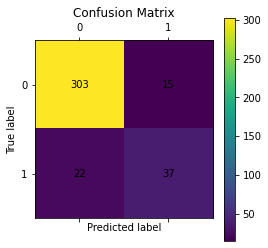

---------------- MODEL:  logistic_regression
Best params: {'C': 0.06320462867496969, 'class_weight': None, 'max_iter': 10000, 'solver': 'liblinear'}
Train accuracy: 0.8837209302325582
Test accuracy: 0.8779840848806366
Train classification report:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      1281
         1.0       0.68      0.41      0.51       224

    accuracy                           0.88      1505
   macro avg       0.79      0.69      0.72      1505
weighted avg       0.87      0.88      0.87      1505

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       318
         1.0       0.67      0.44      0.53        59

    accuracy                           0.88       377
   macro avg       0.78      0.70      0.73       377
weighted avg       0.87      0.88      0.87       377



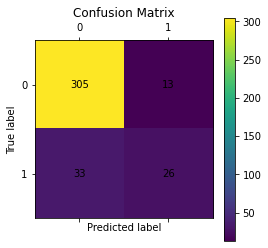

---------------- MODEL:  bayes
Train accuracy: 0.837873754152824
Test accuracy: 0.8567639257294429
Train classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1281
         1.0       0.47      0.75      0.58       224

    accuracy                           0.84      1505
   macro avg       0.71      0.80      0.74      1505
weighted avg       0.88      0.84      0.85      1505

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91       318
         1.0       0.53      0.83      0.64        59

    accuracy                           0.86       377
   macro avg       0.75      0.85      0.78       377
weighted avg       0.90      0.86      0.87       377



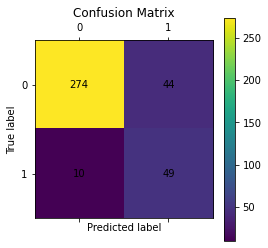

---------------- MODEL:  svm
Best params: {'C': 1.295785408228576, 'gamma': 0.2745805148836231, 'kernel': 'rbf', 'probability': True, 'shrinking': True}
Train accuracy: 0.9295681063122924
Test accuracy: 0.9045092838196287
Train classification report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      1281
         1.0       0.90      0.59      0.72       224

    accuracy                           0.93      1505
   macro avg       0.92      0.79      0.84      1505
weighted avg       0.93      0.93      0.92      1505

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94       318
         1.0       0.78      0.54      0.64        59

    accuracy                           0.90       377
   macro avg       0.85      0.76      0.79       377
weighted avg       0.90      0.90      0.90       377



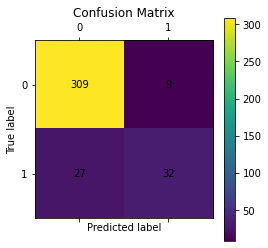

---------------- MODEL:  dt
Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 3}
Train accuracy: 0.8850498338870432
Test accuracy: 0.883289124668435
Train classification report:
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93      1281
         1.0       0.67      0.44      0.53       224

    accuracy                           0.89      1505
   macro avg       0.79      0.70      0.73      1505
weighted avg       0.87      0.89      0.87      1505

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       318
         1.0       0.69      0.46      0.55        59

    accuracy                           0.88       377
   macro avg       0.80      0.71      0.74       377
weighted avg       0.87      0.88      0.87       377



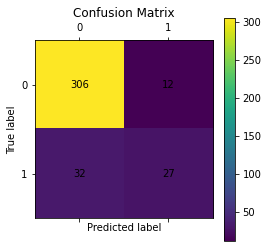

---------------- MODEL:  rf
Best params: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 8}
Train accuracy: 0.9421926910299003
Test accuracy: 0.896551724137931
Train classification report:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      1281
         1.0       0.92      0.67      0.78       224

    accuracy                           0.94      1505
   macro avg       0.93      0.83      0.87      1505
weighted avg       0.94      0.94      0.94      1505

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       318
         1.0       0.72      0.56      0.63        59

    accuracy                           0.90       377
   macro avg       0.82      0.76      0.78       377
weighted avg       0.89      0.90      0.89       377



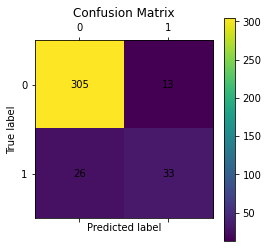

In [ ]:
# Unbalanced data
run_classifiers(all_classifiers, train_X, train_y, test_X, test_y)

0/1 [(128, 'tanh', 0.3), (128, 'tanh', 0.3), (128, 'tanh', 0.3)] lr=0.01 ep=355 acc=0.8837209343910217
Best model: [(128, 'tanh', 0.3), (128, 'tanh', 0.3), (128, 'tanh', 0.3)]
Best lr_rate: 0.01
Best epoch: 355
Train accuracy: 0.9991694352159468
Validation accuracy: 0.8737541528239202
Test accuracy: 0.8938992042440318
Train classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1022
         1.0       1.00      0.99      1.00       182

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204

Validation classification report:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93       259
         1.0       0.54      0.60      0.57        42

    accuracy                           0.87       301
   macro avg       0.74      0.76      0.75       301
weighted avg      

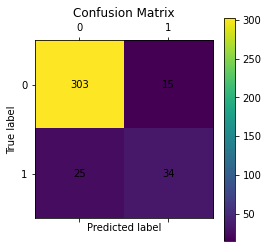

In [ ]:
# Neural network is treated separatedly given its higher complexity.

# Run NN with Unbalanced data
run_nn(train_X, train_y, test_X, test_y, balanced=False)

---------------- MODEL:  knn
Best params: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
Train accuracy: 0.9964871194379391
Test accuracy: 0.8673740053050398
Train classification report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1281
         1.0       1.00      0.99      1.00      1281

    accuracy                           1.00      2562
   macro avg       1.00      1.00      1.00      2562
weighted avg       1.00      1.00      1.00      2562

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       318
         1.0       0.56      0.68      0.62        59

    accuracy                           0.87       377
   macro avg       0.75      0.79      0.77       377
weighted avg       0.88      0.87      0.87       377



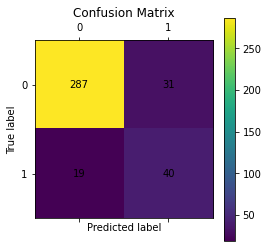

---------------- MODEL:  logistic_regression
Best params: {'C': 0.4839401457219079, 'class_weight': 'balanced', 'max_iter': 10000, 'solver': 'newton-cg'}
Train accuracy: 0.8481654957064794
Test accuracy: 0.8620689655172413
Train classification report:
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84      1281
         1.0       0.82      0.89      0.85      1281

    accuracy                           0.85      2562
   macro avg       0.85      0.85      0.85      2562
weighted avg       0.85      0.85      0.85      2562

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91       318
         1.0       0.53      0.93      0.68        59

    accuracy                           0.86       377
   macro avg       0.76      0.89      0.80       377
weighted avg       0.91      0.86      0.88       377



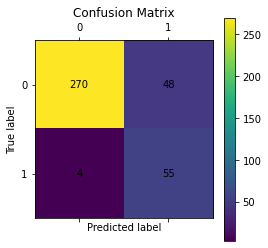

---------------- MODEL:  bayes
Train accuracy: 0.8524590163934426
Test accuracy: 0.830238726790451
Train classification report:
              precision    recall  f1-score   support

         0.0       0.90      0.80      0.84      1281
         1.0       0.82      0.91      0.86      1281

    accuracy                           0.85      2562
   macro avg       0.86      0.85      0.85      2562
weighted avg       0.86      0.85      0.85      2562

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89       318
         1.0       0.48      0.93      0.63        59

    accuracy                           0.83       377
   macro avg       0.73      0.87      0.76       377
weighted avg       0.91      0.83      0.85       377



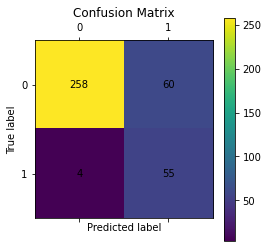

---------------- MODEL:  svm
Best params: {'C': 1.2548468024660122, 'gamma': 0.44333171274944194, 'kernel': 'rbf', 'probability': True, 'shrinking': True}
Train accuracy: 0.9551131928181108
Test accuracy: 0.883289124668435
Train classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95      1281
         1.0       0.92      0.99      0.96      1281

    accuracy                           0.96      2562
   macro avg       0.96      0.96      0.96      2562
weighted avg       0.96      0.96      0.96      2562

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       318
         1.0       0.59      0.80      0.68        59

    accuracy                           0.88       377
   macro avg       0.78      0.85      0.80       377
weighted avg       0.90      0.88      0.89       377



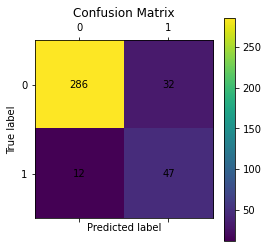

---------------- MODEL:  dt
Best params: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 4}
Train accuracy: 0.9305230288836847
Test accuracy: 0.870026525198939
Train classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      1281
         1.0       0.91      0.96      0.93      1281

    accuracy                           0.93      2562
   macro avg       0.93      0.93      0.93      2562
weighted avg       0.93      0.93      0.93      2562

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92       318
         1.0       0.56      0.83      0.67        59

    accuracy                           0.87       377
   macro avg       0.76      0.85      0.79       377
weighted avg       0.90      0.87      0.88       377



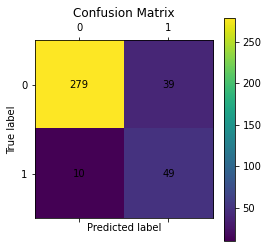

---------------- MODEL:  rf
Best params: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 4}
Train accuracy: 1.0
Test accuracy: 0.896551724137931
Train classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1281
         1.0       1.00      1.00      1.00      1281

    accuracy                           1.00      2562
   macro avg       1.00      1.00      1.00      2562
weighted avg       1.00      1.00      1.00      2562

Test Classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       318
         1.0       0.64      0.80      0.71        59

    accuracy                           0.90       377
   macro avg       0.80      0.86      0.82       377
weighted avg       0.91      0.90      0.90       377



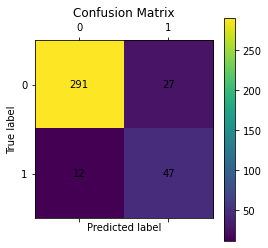

In [ ]:
# Balanced data (SMOTE)
run_classifiers(all_classifiers, balanced_train_X, balanced_train_y, test_X, test_y)

0/1 [(128, 'relu', 0.5), (128, 'relu', 0.5), (128, 'relu', 0.5)] lr=0.006670000000000001 ep=340 acc=0.8936877250671387
Best model: [(128, 'relu', 0.5), (128, 'relu', 0.5), (128, 'relu', 0.5)]
Best lr_rate: 0.006670000000000001
Best epoch: 340
Train accuracy: 0.9990215264187867
Validation accuracy: 0.9003322259136213
Test accuracy: 0.9071618037135278
Train classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1022
         1.0       1.00      1.00      1.00      1022

    accuracy                           1.00      2044
   macro avg       1.00      1.00      1.00      2044
weighted avg       1.00      1.00      1.00      2044

Validation classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       259
         1.0       0.62      0.74      0.67        42

    accuracy                           0.90       301
   macro avg       0.79      0.83      0

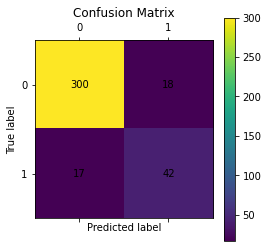

In [ ]:
# Run NN with Balanced data (SMOTE)
run_nn(train_X, train_y, test_X, test_y, balanced=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52344550-8347-4668-936e-f505b5adca8e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>